Ноутбук к экспериментами по визуализации синтетических моделей. 

status: done

In [2]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths

import create_model_helper as cmh
import test_vs_original_columns_helper as tvsoch
import distances_helper as dh
import build_convex_hull_helper as bchh

0.8.1


In [ ]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
print config.models_file_name

In [ ]:
models_file = open(config.models_file_name, 'a')

In [6]:
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_model_pickle(_model_name, _distance_name=None):
    phi = load_pickle_file('phi_{}.p'.format(_model_name))
    theta = load_pickle_file('theta_{}.p'.format(_model_name))
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name))
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name))
    else:
        distances = None
    return phi, theta, saved_top_tokens, distances

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Creating syntetic models (3):

In [ ]:
def create_syntetic_model_1(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m1__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model
def create_syntetic_model_2(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m2__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model
def create_syntetic_model_3(n_iteration):
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=100+n_iteration, n_doc_passes=5, seed_value=100,
                             n_top_tokens=15, p_mass_threshold=0.25, class_name='ngramm')
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, _model_name='model_100_m3__it_{}'.format(n_iteration),
                                  is_correct_topic_fn=check_topic_correctness)
    return tmp_model
def get_distances(phi):
    different_distances = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
    return different_distances
def get_not_diagonal_flatten_values(mat):
    not_diagonal_values = []
    for row_ind, row in enumerate(mat):
        for col_ind, val in enumerate(row):
            if row_ind != col_ind:
                not_diagonal_values.append(val)
    return not_diagonal_values
def plot_different_distances(different_distances):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    vals = different_distances[dh.kl_dist].values.flatten()
    sns.distplot(vals, color='y', ax=ax1, label='kl')
    vals = different_distances[dh.kl_sym_dist].values.flatten()
    sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    vals = different_distances[dh.jaccard_dist].values.flatten()
    sns.distplot(vals, color='r', ax=ax2, label='jaccard')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    vals = different_distances[dh.cos_dist].values.flatten()
    sns.distplot(vals,  color='b', ax=ax2, label='cos')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='b', ax=ax3, label='cos')

    vals = different_distances[dh.hellinger_dist].values.flatten()
    sns.distplot(vals, color='g', ax=ax2, label='hellinger')
    plt.xlim(0.6, 1)
    sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()
def plot_different_opt_fun(different_opt_results):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))    
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.jaccard_dist].iteritems()]
    sns.distplot(opt_fun_values, color='r', ax=ax1, label='jaccard')
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.cos_dist].iteritems()]    
    sns.distplot(opt_fun_values,  color='b', ax=ax1, label='cos')
    opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.hellinger_dist].iteritems()]   
    sns.distplot(opt_fun_values, color='g', ax=ax1, label='hellinger')
    
    if dh.kl_dist in different_opt_results.keys():
        opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.kl_dist].iteritems()]   
        sns.distplot(opt_fun_values, color='y', ax=ax3, label='kl')
    if dh.kl_sym_dist in different_opt_results.keys():    
        opt_fun_values = [opt_res['fun'] for topic, opt_res in different_opt_results[dh.kl_sym_dist].iteritems()]   
        sns.distplot(opt_fun_values, color='m', ax=ax3, label='kl_sym')    
    ax1.legend()
    ax2.legend()
def print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_results, different_distances):
    def print_single_distance1(different_opt_results, dist_fn):
        print dist_fn, "===================================================="
        if dist_fn in different_opt_results.keys():
            for topic, opt_res in different_opt_results[dist_fn].iteritems():
                coeff_col_name = sorted(zip(opt_res['x'], opt_res['column_names']))[::-1][0][1]
                closest_col_dist = different_distances[dist_fn].loc[coeff_col_name, :].sort_values()[1:2]
                print 'Opt_topic =', topic, opt_res['fun'], ', first x coeff = ', \
                    coeff_col_name, closest_col_dist[0], 'to', closest_col_dist.index[0]
    def print_single_distance(different_opt_results, dist_fn):
        print dist_fn, "===================================================="
        if dist_fn in different_opt_results.keys():
            for topic, opt_res in different_opt_results[dist_fn].iteritems():
                closest_col_dist = different_distances[dist_fn].loc[topic, :].sort_values()[1:2]
                print 'Opt_topic =', topic, opt_res['fun'], ', closest topic =', \
                    closest_col_dist.index[0], closest_col_dist[0]
    print_single_distance(different_opt_results, dh.jaccard_dist)
    print_single_distance(different_opt_results, dh.cos_dist)
    print_single_distance(different_opt_results, dh.hellinger_dist)
    print_single_distance(different_opt_results, dh.kl_dist)
    print_single_distance(different_opt_results, dh.kl_sym_dist)
def check_topic_correctness(topic_phi, topic_theta=[], _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if len(topic_theta):
        # topic must have at least one doc, assigned to it
        topic_theta = topic_theta.values
        topic_docs_count_rule = len(topic_theta[np.where(topic_theta != 0)[0]]) >= 1
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule

In [ ]:
model1 = create_syntetic_model_1(0)
model2 = create_syntetic_model_2(0)
model3 = create_syntetic_model_3(0)

In [8]:
phi1, theta1, _ = save_model_pickle('model1', model1)
phi2, theta2, _ = save_model_pickle('model2', model2)
phi3, theta3, _ = save_model_pickle('model3', model3)

In [8]:
phi1, theta1, _, _ = load_model_pickle('model1')
phi2, theta2, _, _ = load_model_pickle('model2')
phi3, theta3, _, _ = load_model_pickle('model3')

# Model 1, fixed near-zero values

Processed th = 40, original columns count = 100      

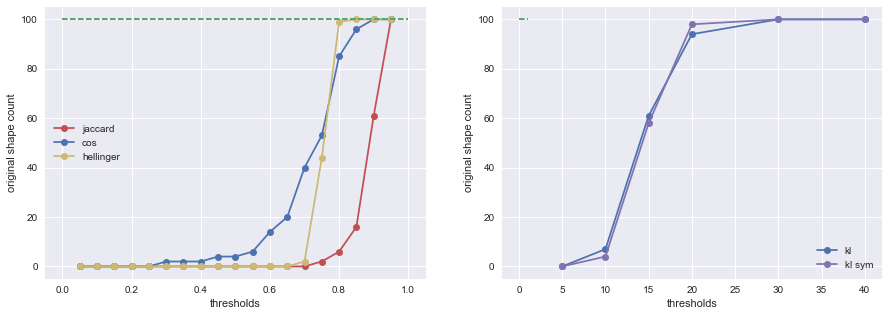

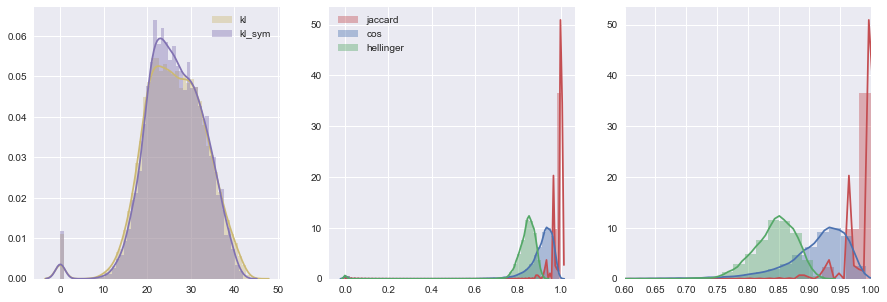

In [9]:
% matplotlib inline

# диагональные значения нулевые - поэтому внутри алгоритма они заменяются на большое значение (=100) и не выбираются
# фактически это поиск ближайшей колонки
different_distances1 = get_distances(phi1)
different_distances_to_original1 = tvsoch.get_test_to_original_result_different_distances(phi1, phi1)
tvsoch.plot_original_columns_count_different_distances(different_distances_to_original1, n_original_columns_count=100)
plot_different_distances(different_distances1)

Поиск ближайшей похожей колонки, не равной самой себе. Видно, что при использовании hellinger, jaccard -- порог довольно таки высокий (>= 0.7) --- значит темы довольно-таки различные. Но после преодолевания порогового значения любой теме можно найти ближайшую. 

С cos нужно разобраться. Кажется, что оно завышенно-либеральное и сразу может принять за ближайшую какую-то колонку?  

KL не отобразился, потому что значения не от 0 до 1 - нужно другие thesholds подавать (todo)

# Model 2

Processed th = 40, original columns count = 33       

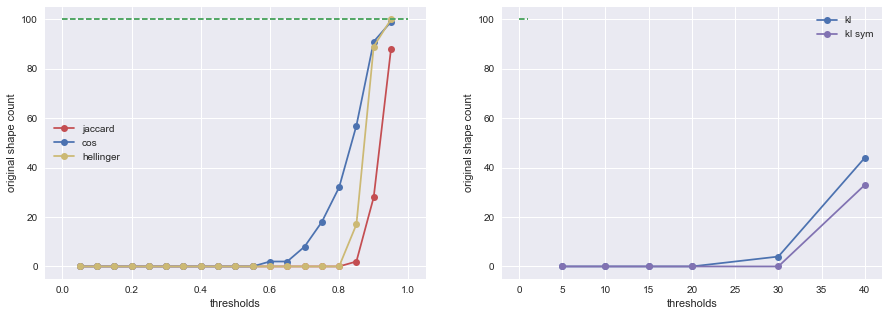

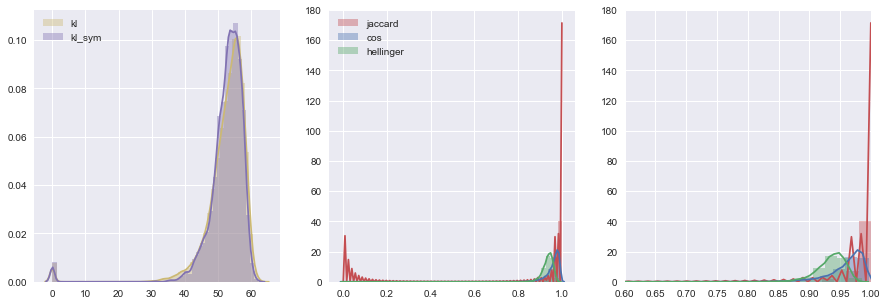

In [10]:
different_distances2 = get_distances(phi2)
different_distances_to_original2 = tvsoch.get_test_to_original_result_different_distances(phi2, phi2)
tvsoch.plot_original_columns_count_different_distances(different_distances_to_original2, n_original_columns_count=100)
plot_different_distances(different_distances2)

# Model 3

Processed th = 40, original columns count = 4       

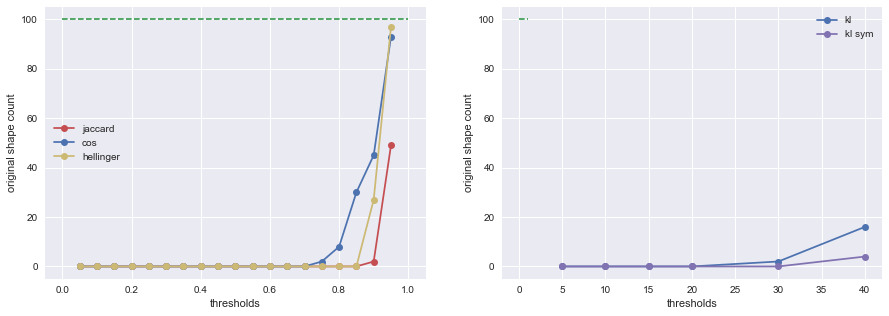

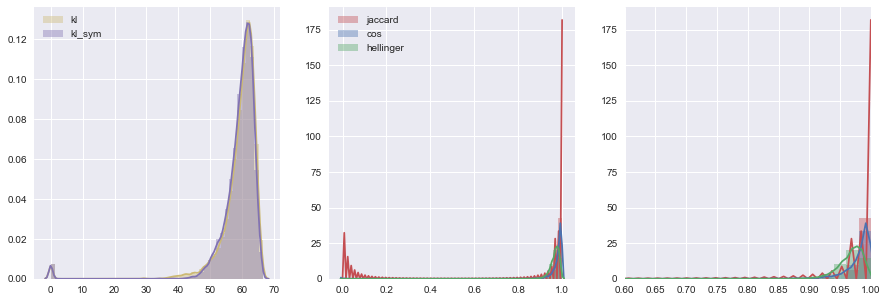

In [11]:
different_distances3 = get_distances(phi3)
different_distances_to_original3 = tvsoch.get_test_to_original_result_different_distances(phi3, phi3)
tvsoch.plot_original_columns_count_different_distances(different_distances_to_original3, n_original_columns_count=100)
plot_different_distances(different_distances3)

Поиск ближайшей похожей колонки, не равной самой себе. 
* m1. Видно, что при использовании hellinger, jaccard -- порог довольно таки высокий (> 0.6) --- значит темы довольно-таки различные. Но после преодолевания порогового значения любой теме можно найти ближайшую.
* m2-m3. Чем регуляризованнее модель, тем выше порог. То есть тем сложнее найти наиболее похожую тему. 
* m3. Некоторые темы настолько разные (или наоборот сильно похожие и пара уже была занята), что даже при очень высоком пороге не найти соотвествие (не набрать 100 тем). 
По расстояниям: распределения расстояний нерегуляризованных моделей более размазанные и близкие.

# Opt res
Посмотрим, как темы проектируются на остальные темы (не равные им). Как близко? Через сколько коэффициентов выражаются?

In [17]:
N_CLOSEST_TOPICS = 20
def get_different_opt_res(phi, different_distances):
    different_opts = {}
    distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist]#, dh.kl_dist, dh.kl_sym_dist]
    for dist_fn in distances:
        print 'Processing =', dist_fn
        different_opts[dist_fn] = bchh.get_optimization_result_one_matrix(dist_fn, None, phi, different_distances[dist_fn],
                                       [], N_CLOSEST_TOPICS, _debug_print=False)
    return different_opts

In [18]:
different_opt_res_phi1 = get_different_opt_res(phi1, different_distances1)
save_pickle_file(different_opt_res_phi1, 'different_opt_res_phi1.p')

Processing = <function jaccard_dist at 0x000000000BF344A8>
Processing = <function cos_dist at 0x000000000BF34588>
Processing = <function hellinger_dist at 0x000000000BF345F8>


In [19]:
different_opt_res_phi2 = get_different_opt_res(phi2, different_distances2)
save_pickle_file(different_opt_res_phi2, 'different_opt_res_phi2.p')

Processing = <function jaccard_dist at 0x000000000BF344A8>
Processing = <function cos_dist at 0x000000000BF34588>
Processing = <function hellinger_dist at 0x000000000BF345F8>


In [20]:
different_opt_res_phi3 = get_different_opt_res(phi3, different_distances3)
save_pickle_file(different_opt_res_phi3, 'different_opt_res_phi3.p')

Processing = <function jaccard_dist at 0x000000000BF344A8>
Processing = <function cos_dist at 0x000000000BF34588>
Processing = <function hellinger_dist at 0x000000000BF345F8>


In [21]:
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    col_val = col.copy()
    if cut_th != None:
        col_val[col_val < cut_th] = 0
    for val in col_val.sort_values()[::-1]:
        if val != 0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    cut_th_x, cut_th_probs = 5*1e-2, 1e-3
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=cut_th_x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_th = [get_words_close_to_th_count(col, cut_th=cut_th_probs)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    sns.distplot(grans_th, color='b', bins=5, ax=ax4)
    title = '{} {} \nx_count_grans_mean = {}; x_count_grans_mean_th={}\nth={}'.\
        format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th, cut_th_x)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)
    title = '{} {} \ngrans_mean_th = {}, cut_th={}'.format(name, phi.shape, np.mean(grans_th), cut_th_probs)
    ax4.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean



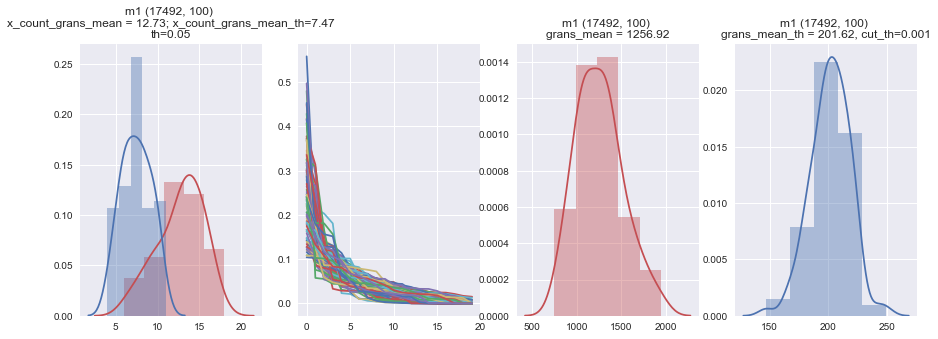

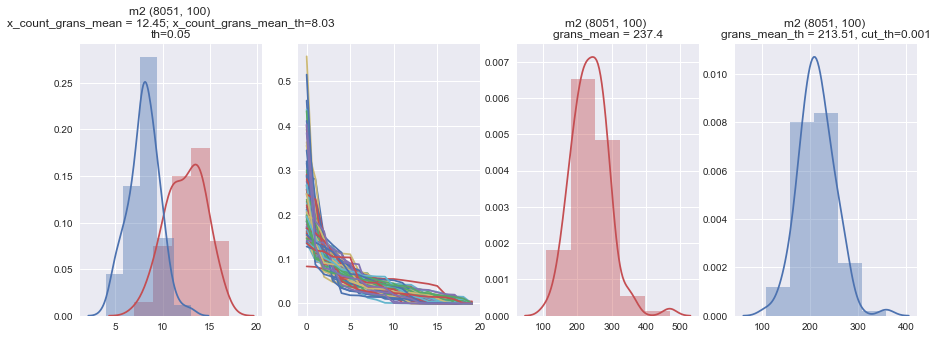

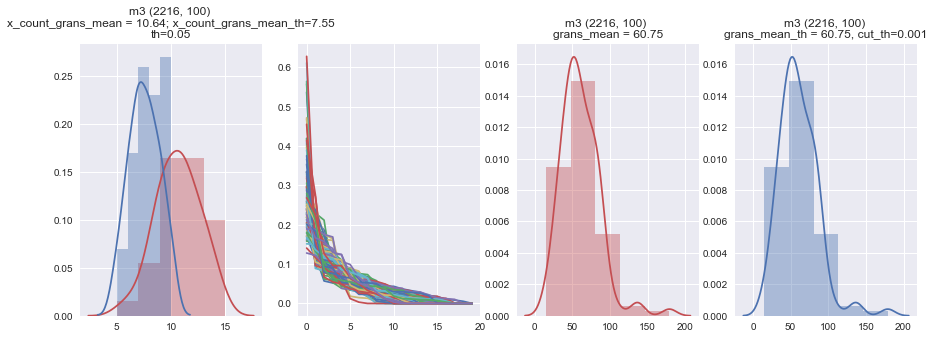

In [22]:
_,_,_,_ = get_and_plot_granularity(phi1, different_opt_res_phi1[dh.hellinger_dist], 'm1')
_,_,_,_ = get_and_plot_granularity(phi2, different_opt_res_phi2[dh.hellinger_dist], 'm2')
_,_,_,_ = get_and_plot_granularity(phi3, different_opt_res_phi3[dh.hellinger_dist], 'm3')

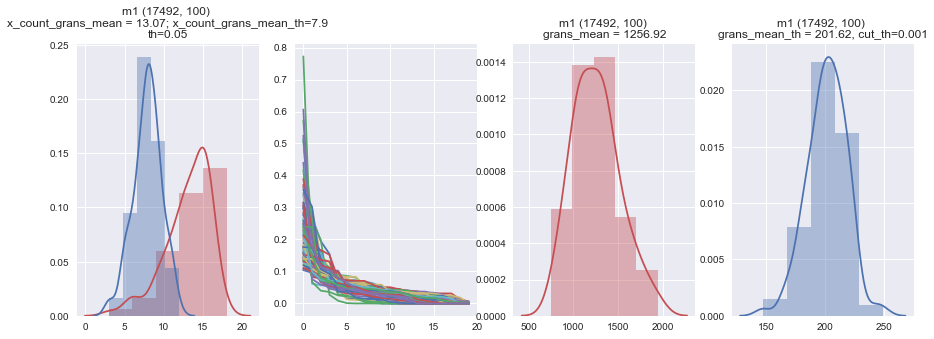

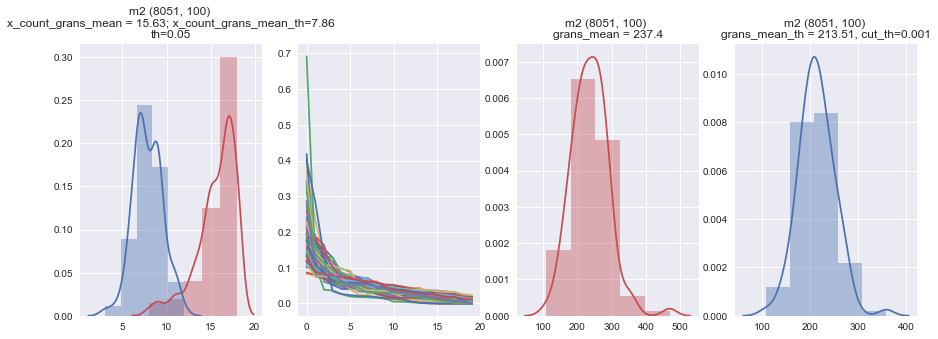

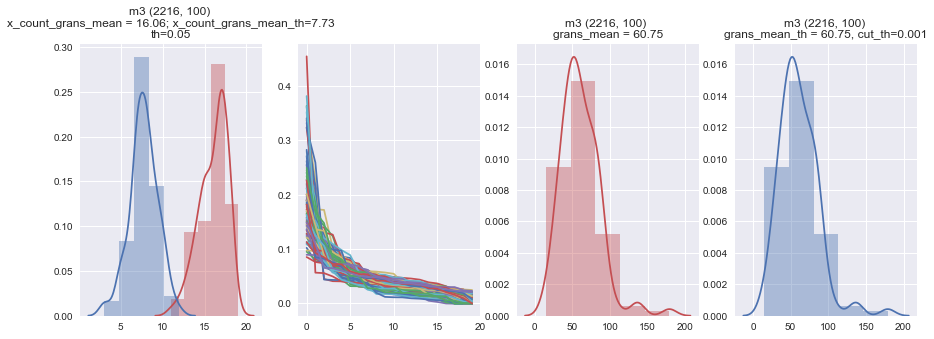

In [23]:
_,_,_,_ = get_and_plot_granularity(phi1, different_opt_res_phi1[dh.cos_dist], 'm1')
_,_,_,_ = get_and_plot_granularity(phi2, different_opt_res_phi2[dh.cos_dist], 'm2')
_,_,_,_ = get_and_plot_granularity(phi3, different_opt_res_phi3[dh.cos_dist], 'm3')

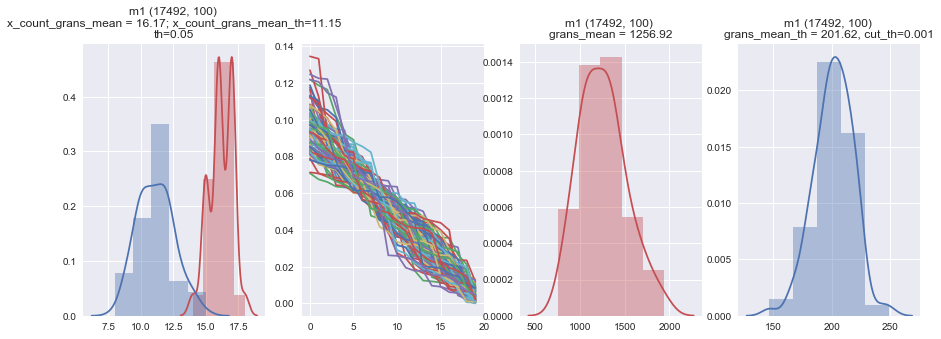

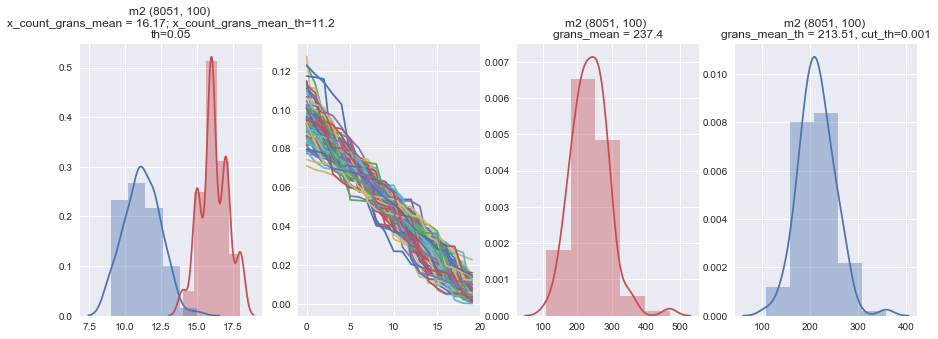

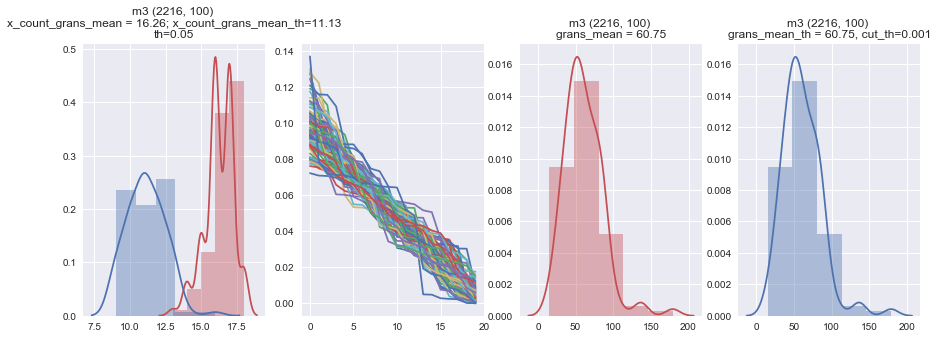

In [24]:
_,_,_,_ = get_and_plot_granularity(phi1, different_opt_res_phi1[dh.jaccard_dist], 'm1')
_,_,_,_ = get_and_plot_granularity(phi2, different_opt_res_phi2[dh.jaccard_dist], 'm2')
_,_,_,_ = get_and_plot_granularity(phi3, different_opt_res_phi3[dh.jaccard_dist], 'm3')

* с характеристикой gran topics моделей оч. сложно. m3: без зануления 0.05 --  60, с -- 4; m1: 1200 vs 1.56 --- очень большая разница, получается, что огромное число вероятностей - около 0 !! хотя kernel size -- адекватный для всех моделей
* все расстояния, все модели  -- число коэффициентов большое: от 7 до 12
* расхождения с avg kernel size, неплохо выводить не просто top слова темы, а слова и их вероятности

In [25]:
different_opt_res_phi1 = load_pickle_file('different_opt_res_phi1.p')
different_opt_res_phi2 = load_pickle_file('different_opt_res_phi2.p')
different_opt_res_phi3 = load_pickle_file('different_opt_res_phi3.p')

Посмотрим, а как близко найденная л/к в опт приближала колонки (opt_fun) распределение. И на каком расстоянии находится ближайшая колонка.

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


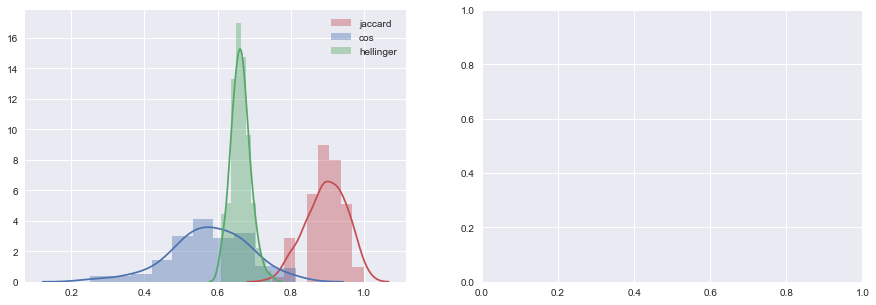

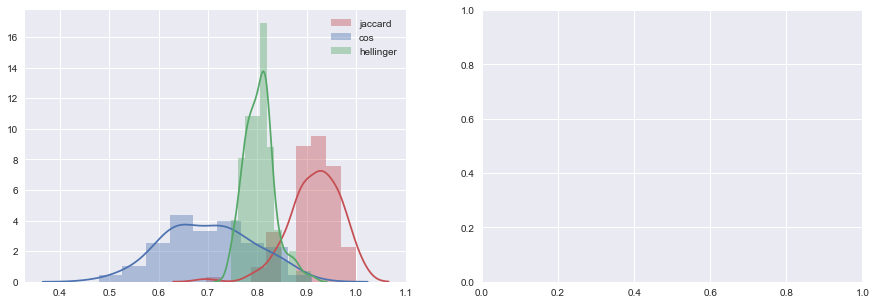

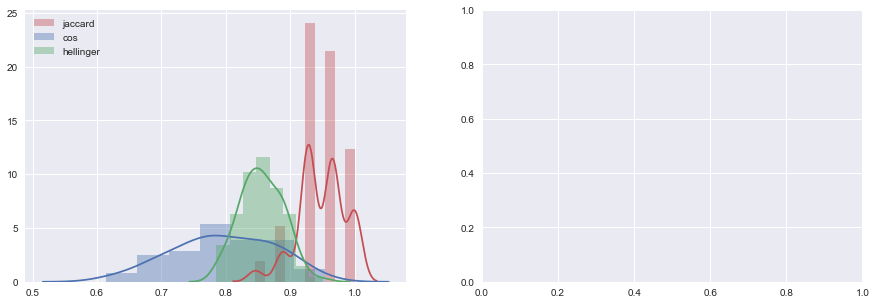

In [26]:
%matplotlib inline
plot_different_opt_fun(different_opt_res_phi1)
plot_different_opt_fun(different_opt_res_phi2)
plot_different_opt_fun(different_opt_res_phi3)

In [27]:
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi1, different_distances1)
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi2, different_distances2)
print_different_opt_fun_and_distance_to_first_coeff_closest_column(different_opt_res_phi3, different_distances3)

<function jaccard_dist at 0x000000000BF344A8> ====================================================
Opt_topic = topic_68 0.965517241379 , closest topic = topic_65 0.888888888889
Opt_topic = topic_69 0.888888888889 , closest topic = topic_58 0.928571428571
Opt_topic = topic_62 0.8 , closest topic = topic_91 0.888888888889
Opt_topic = topic_63 0.888888888889 , closest topic = topic_10 0.928571428571
Opt_topic = topic_60 0.928571428571 , closest topic = topic_49 0.928571428571
Opt_topic = topic_61 0.846153846154 , closest topic = topic_5 0.888888888889
Opt_topic = topic_66 0.888888888889 , closest topic = topic_78 0.888888888889
Opt_topic = topic_67 0.928571428571 , closest topic = topic_34 0.888888888889
Opt_topic = topic_64 0.846153846154 , closest topic = topic_2 0.75
Opt_topic = topic_65 0.888888888889 , closest topic = topic_87 0.888888888889
Opt_topic = topic_79 0.846153846154 , closest topic = topic_16 0.888888888889
Opt_topic = topic_78 0.928571428571 , closest topic = topic_71 0.8

In [9]:
dh.jaccard_dist(phi1.iloc[:,1], phi1.iloc[:,1])

0.0

Видно, что opt_fun (расстояние от найденной оптимальной л/к) ближе, чем просто поиск ближайшей колонки. Но, кстати, не всегда (только topic_68 ?)  .todo: check

* расхождения с avg kernel size?
* проверить kl opt

## check saved matrices

In [8]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file

In [10]:
config_m1 = ConfigPaths('config_sample_m1.cfg')
print config_m1.models_file_name
phi_original_m1, theta_original_m1 = load_pickle_file('phi_model1.p', config_m1.output_batches_path), load_pickle_file('theta_model1.p', config_m1.output_batches_path)
phi_nwt_original_m1 = pd.DataFrame(0, index=phi_original_m1.index, columns=[])

config_m2 = ConfigPaths('config_sample_m2.cfg')
print config_m2.models_file_name
phi_original_m2, theta_original_m2 = load_pickle_file('phi_model2.p', config_m2.output_batches_path), load_pickle_file('theta_model2.p', config_m2.output_batches_path)
phi_nwt_original_m2 = pd.DataFrame(0, index=phi_original_m2.index, columns=[])

config_m3 = ConfigPaths('config_sample_m3.cfg')
print config_m3.models_file_name
phi_original_m3, theta_original_m3 = load_pickle_file('phi_model3.p', config_m3.output_batches_path), load_pickle_file('theta_model3.p', config_m3.output_batches_path)
phi_nwt_original_m3 = pd.DataFrame(0, index=phi_original_m3.index, columns=[])

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model1\np_01_04_original_models\models.txt
Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model2\np_01_04_original_models\models.txt
Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_01_04_original_models\models.txt


In [12]:
print phi_original_m1.shape, theta_original_m1.shape
print phi_original_m2.shape, theta_original_m2.shape
print phi_original_m3.shape, theta_original_m3.shape

(17492, 100) (100, 3446)
(8051, 100) (100, 3446)
(2216, 100) (100, 3446)


* Почему разное число слов в словарике??? Получается, что в 3ей модели число документов больше, чем слов.
* Потому что из оригинальной матрицы были удалены слова, которые не реализовались ни в одной теме. Изначально было 19321 слов. 